In [28]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def target(FTHG, FTAG):
    if (FTHG > FTAG):
        return 1
    return 0

leauge = "P1"

data = [
    f"https://www.football-data.co.uk/mmz4281/1920/{leauge}.csv",
    f"https://www.football-data.co.uk/mmz4281/2021/{leauge}.csv",
    f"https://www.football-data.co.uk/mmz4281/2122/{leauge}.csv"
]

In [29]:
li = []

for leauge in data:
    df = pd.read_csv(leauge)
    li.append(df)

df = pd.concat(li)

df = df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "B365CH", "B365CD", "B365CA", "B365C>2.5", "B365C<2.5"]]
df["target"] = np.vectorize(target)(df["FTHG"], df["FTAG"])
df = df.reset_index(drop=True)

print(df.isnull().sum().sum())
df = df.dropna()

df.tail()

0


,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365CH,B365CD,B365CA,B365C>2.5,B365C<2.5,target
841,12/03/2022,Belenenses,Boavista,0,0,3.50,3.25,2.10,2.25,1.61,0
842,13/03/2022,Maritimo,Guimaraes,0,1,2.70,3.10,2.80,2.05,1.75,0
843,13/03/2022,Porto,Tondela,4,0,1.12,9.50,15.00,1.33,3.40,1
844,13/03/2022,Sp Braga,Gil Vicente,0,1,1.72,3.80,4.50,1.80,2.00,0
845,14/03/2022,Moreirense,Sp Lisbon,0,2,7.00,4.50,1.44,2.02,1.83,0


<AxesSubplot:xlabel='target', ylabel='count'>

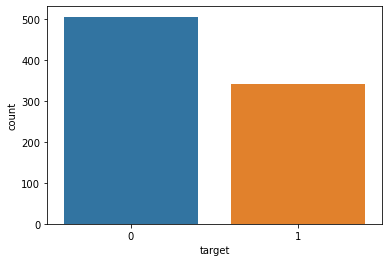

In [30]:
sns.countplot(data=df, x="target")

In [31]:
team_data = pd.get_dummies(df[["HomeTeam", "AwayTeam"]])
odds = df[["B365CH", "B365CD", "B365CA", "B365C>2.5", "B365C<2.5"]]

X = pd.concat([team_data, odds], axis=1)
y = df["target"]

X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, random_state=101)
print(X_train.shape, y_train.shape)

X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=101)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print()
scores = []
for i in np.arange(1, 201, 1):
    model = RandomForestClassifier(random_state=101, n_estimators=i)
    model.fit(X_train, y_train);
    score = model.score(X_val, y_val)
    scores.append(score)
    
print(np.argmax(scores) + 1)

(592, 51) (592,)
(127, 51) (127,)
(127, 51) (127,)

151


In [32]:
model = RandomForestClassifier(random_state=101, n_estimators=151)
model.fit(X_train, y_train);
print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.69      0.84      0.76        73
           1       0.69      0.50      0.58        54

    accuracy                           0.69       127
   macro avg       0.69      0.67      0.67       127
weighted avg       0.69      0.69      0.68       127



In [33]:
y_val.value_counts() / len(X_val)

0    0.574803
1    0.425197
Name: target, dtype: float64

In [34]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.85      0.73        73
           1       0.63      0.35      0.45        54

    accuracy                           0.64       127
   macro avg       0.64      0.60      0.59       127
weighted avg       0.64      0.64      0.61       127



In [35]:
y_test.value_counts() / len(X_test)

0    0.574803
1    0.425197
Name: target, dtype: float64

In [48]:
test = pd.DataFrame(columns=team_data.columns, data=np.zeros(len(team_data.columns)).reshape(1, len(team_data.columns)))

In [49]:
test["HomeTeam_Napoli"] = 1
test["AwayTeam_Udinese"] = 1

test["B365CH"] = 1.53
test["B365CD"] = 4.2
test["B365CA"] = 6
test["B365C>2.5"] = 1.84
test["B365C<2.5"] = 2.06

model.predict_proba(test)

array([[0.64220183, 0.28440367, 0.0733945 ]])

In [50]:
1 / model.predict_proba(test)

array([[ 1.55714286,  3.51612903, 13.625     ]])